# Automated Ads

Writing ads for a product is usually reserved for humans. What would happen if we tried to make this process easier by automating the following processes:

- 1) Ad title/ headline suggestion
- 2) Ad title/ ad text automatic generation

This notebook contains my attempts to accomplish the first task: suggest ad titles that are relevant for a particular ad. I attempt two approaches:
1) Unsupervised Models
2) Supervised Learning Models:
   - Logistic Regression
   - Random Forest
   - XGBoost
   - RNN
   
The data set comes from Russian-speaking countries and was collected from October 2016 to January 2017. It includes ads in Russian for a vast variety of products. The data set came to my possession from a public source: https://www.kaggle.com/kotobotov/context-advertising.

# I. Importing the Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pymystem3 import Mystem
from stop_words import get_stop_words
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import gensim
from gensim.models import word2vec
from sklearn.model_selection import cross_val_predict
import re
import string
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.utils import shuffle
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings('ignore')


import keras.utils as ku 
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, Embedding, Dropout, GRU, Bidirectional
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization

Using TensorFlow backend.


# II. Preprocessing The Data

In [2]:
ads = pd.read_csv('/Users/admin/Documents/contextAdvertising1.csv')

In [3]:
ads.shape

(799999, 3)

In [4]:
ads.head()

,atitle,atext,adomain
0,Клуб активного отдыха «0.67»,Детский пейнтбол. Спортивный пейнтбол. Тактиче...,0-67.relax.by
1,Антигравитационный чехол IPhone 5,Успейте купить антигравитационный чехол для IP...,0-antigravity.ru
2,Антигравитационный чехол купить!,Антигравитационный чехол для телефона купить з...,0-antigravity.ru
3,Беспроцентный заем от Moneyveo,Без справок! Получите до 3 000 грн. на карту п...,0-credit.moneyveo.ua
4,Беспроцентный заем сотруднику,Акция! Получите Кредит Онлайн под 0%. Без Спра...,0-credit.moneyveo.ua


In [5]:
ads.nunique()

atitle     571923
atext      350006
adomain     19181
dtype: int64

In [6]:
(ads['atitle'] + ads['atext']).nunique()

792924

In [7]:
unique_adstext =ads.drop_duplicates(subset = ['atext'], keep=False)

In [8]:
unique_adstext.nunique()

atitle     234515
atext      323003
adomain      4838
dtype: int64

In [9]:
#it appears that even after we remove duplicate ads texts, we still have duplicate titles 
unique_adstext['atitle'].nunique()

234515

In [10]:
unique =unique_adstext.drop_duplicates(subset = ['atitle'], keep=False)

In [11]:
unique.nunique()

atitle     204601
atext      204601
adomain      4589
dtype: int64

In [12]:
unique.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 204601 entries, 0 to 772521
Data columns (total 3 columns):
atitle     204601 non-null object
atext      204601 non-null object
adomain    204601 non-null object
dtypes: object(3)
memory usage: 6.2+ MB


In [13]:
unique.head()

,atitle,atext,adomain
0,Клуб активного отдыха «0.67»,Детский пейнтбол. Спортивный пейнтбол. Тактиче...,0-67.relax.by
1,Антигравитационный чехол IPhone 5,Успейте купить антигравитационный чехол для IP...,0-antigravity.ru
2,Антигравитационный чехол купить!,Антигравитационный чехол для телефона купить з...,0-antigravity.ru
3,Беспроцентный заем от Moneyveo,Без справок! Получите до 3 000 грн. на карту п...,0-credit.moneyveo.ua
4,Беспроцентный заем сотруднику,Акция! Получите Кредит Онлайн под 0%. Без Спра...,0-credit.moneyveo.ua


In [14]:
unique['atext'][:5]

0    Детский пейнтбол. Спортивный пейнтбол. Тактиче...
1    Успейте купить антигравитационный чехол для IP...
2    Антигравитационный чехол для телефона купить з...
3    Без справок! Получите до 3 000 грн. на карту п...
4    Акция! Получите Кредит Онлайн под 0%. Без Спра...
Name: atext, dtype: object

In [15]:
type(unique['atext'])

pandas.core.series.Series

In [16]:
#include all the punctuation signs\n",
def punctuation_remover(row):
    punctuation = '!"#$&\'()*+,-./:;<=>?@[\\]^_`{|}~«»'
    
    punctuationNoPeriod = "[" + re.sub("\.","", punctuation) + "]"
    row = re.sub(punctuationNoPeriod, " ", str(row))
    #to remove double white spaces and create space after %,
    row = row.replace('  ', ' ')
    row = row.replace('%', '% ')
    return row.strip()


In [17]:
punctuation_remover(unique['atext'][0])

'Детский пейнтбол Спортивный пейнтбол Тактический пейнтбол Выездные игры'

In [18]:
# remove punctuation from the ads text
unique['atext'] = unique['atext'].apply(punctuation_remover)

In [19]:
unique['atitle'] = unique['atitle'].apply(punctuation_remover)

In [20]:
unique['atitle'][:5]

0           Клуб активного отдыха 0 67
1    Антигравитационный чехол IPhone 5
2      Антигравитационный чехол купить
3       Беспроцентный заем от Moneyveo
4        Беспроцентный заем сотруднику
Name: atitle, dtype: object

In [21]:
unique['atext'].iloc[0]

'Детский пейнтбол Спортивный пейнтбол Тактический пейнтбол Выездные игры'

In [22]:
unique = unique.drop_duplicates(subset = ['atitle'], keep=False)

In [23]:
unique = unique.drop_duplicates(subset = ['atext'], keep=False)

In [24]:
unique.nunique()

atitle     200718
atext      200718
adomain      4534
dtype: int64

In [25]:
m = Mystem()
def text_parser(series): # do lemmatization if true 
    series_copy = series.copy()
    list_of_strings = []

    for row in series:
        ad_string = ''
        lemmas = m.lemmatize(row)
        for count, lemma in enumerate(lemmas):
            if (lemma !=  ' ' and lemma != '\n' and count < len(lemmas)):
                ad_string += lemma +' ' 
        list_of_strings.append(ad_string.lower())
    return list_of_strings

In [26]:
unique_lem = unique.copy()
unique_lem['atitle'] = text_parser(unique['atitle'])

In [27]:
unique_lem['atext'] = text_parser(unique['atext'])

In [28]:
unique_lem.head()

,atitle,atext,adomain
0,клуб активный отдых 0 67,детский пейнтбол спортивный пейнтбол тактическ...,0-67.relax.by
1,антигравитационный чехол iphone 5,успевать купить антигравитационный чехол для i...,0-antigravity.ru
3,беспроцентный заем от moneyveo,без справка получать до 3 000 грн на карта под...,0-credit.moneyveo.ua
4,беспроцентный заем сотрудник,акция получать кредит онлайн под 0 % без спр...,0-credit.moneyveo.ua
11,аnti gravity case,аnti gravity case – уникальный антигравитаци...,0-gravity.online-shop-2017.ru


In [29]:
unique_lem.shape

(200718, 3)

In [30]:
unique_lem = unique_lem.drop_duplicates(subset = ['atitle'], keep=False)

In [31]:
unique_lem = unique_lem.drop_duplicates(subset = ['atext'], keep=False)

In [32]:
unique_lem = unique_lem.drop_duplicates(keep=False)

In [33]:
unique_lem.shape

(191257, 3)

In [34]:
unique_lem.nunique()

atitle     191257
atext      191257
adomain      4479
dtype: int64

In [35]:
unique_lem.nunique()

atitle     191257
atext      191257
adomain      4479
dtype: int64

In [36]:
unique_lem.shape

(191257, 3)

In [37]:
len(set(unique_lem['atext']))

191257

In [38]:
len(set(unique_lem['atitle']))

191257

In [39]:
unique_lem.isnull().sum()

atitle     0
atext      0
adomain    0
dtype: int64

In [40]:
unique_lem['atitle'] = unique_lem['atitle'].apply(lambda x: x.split())

In [41]:
unique_lem['atext'] = unique_lem['atext'].apply(lambda x: x.split())

In [42]:
X = unique_lem['atext']
y = unique_lem['atitle']

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [44]:
X_test.head()

538096          [bosch, smv, 65m30, от, 1642, 84, доставка]
482436    [быть, в, наличие, плиткорез, на, монорельс, 6...
371034    [купить, баня, из, брус, под, ключ, высокий, к...
201971    [купить, thrustmaster, джойстик, thrustmaster,...
599930    [свитшот, в, интернет, магазин, 3d, футболка, ...
Name: atext, dtype: object

In [45]:
merged_list = X_train + y_train

# III. Training Word2Vec Model

In [46]:
model = word2vec.Word2Vec(
    merged_list,
    workers=4,     
    min_count=5,   
    window=50,      
    sg=0,          
    sample=1e-4,  
    size=300,      
    hs=1           
)


In [47]:
vocab = model.wv.vocab.keys()
print(len(vocab))

19849


In [48]:
def tsne_plot(model):
    #Creates and TSNE model and plots it
    
    labels = []
    tokens = []

    for word in model.wv.vocab:
        if model.wv.vocab[word].count > 1000:
            tokens.append(model[word])
            labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=108)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(20, 20)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

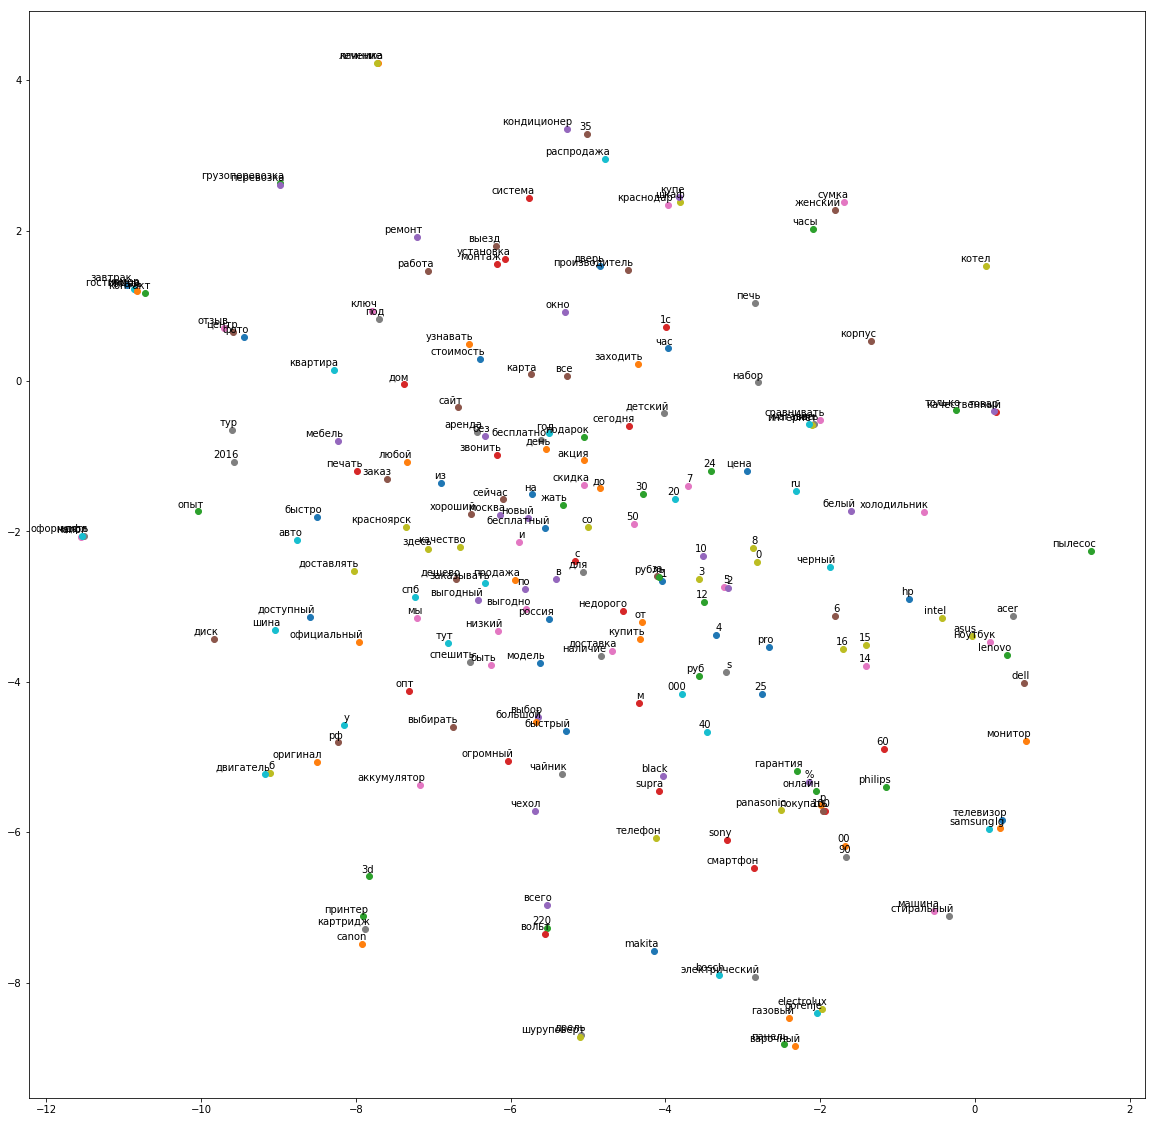

In [49]:
tsne_plot(model)

# IV. Unsupervised Solution

In [50]:
test_df = pd.DataFrame(X_test)

In [51]:
test_df['atitle'] = y_test

In [52]:
test_df.shape

(57378, 2)

In [53]:
test_df.head()

,atext,atitle
538096,"[bosch, smv, 65m30, от, 1642, 84, доставка]","[bosch, smv, 65m30]"
482436,"[быть, в, наличие, плиткорез, на, монорельс, 6...","[плиткорез, на, монорельс, 600, мм]"
371034,"[купить, баня, из, брус, под, ключ, высокий, к...","[купить, баня, из, брус, под, ключ]"
201971,"[купить, thrustmaster, джойстик, thrustmaster,...","[thrustmaster, hotas, warthog, 296072]"
599930,"[свитшот, в, интернет, магазин, 3d, футболка, ...","[свитшот, в, интернет, магазин]"


In [54]:
sample_test_df_checking = test_df.sample(1000, random_state=0)

In [55]:
sample_test_df_checking = sample_test_df_checking.reset_index(drop=True)

In [56]:
sample_test_df_checking.head()

,atext,atitle
0,"[печь, теплодар, топ, купить, здесь, хороший, ...","[печь, теплодар, топ, купить, здесь]"
1,"[покупать, origin, и, др, аккаунт, по, низкий,...","[магазин, игровой, аккаунт, origin]"
2,"[обновлять, навигатор, garmin, nuvi, жать]","[обновлять, навигатор, garmin, nuvi]"
3,"[полукомбинезон, crockid, сравнивать, цена, ве...","[полукомбинезон, crockid]"
4,"[декоративный, зеркало, сравнивать, цена, весь...","[декоративный, зеркало]"


In [57]:
from sklearn.preprocessing import normalize


def result_vector(text):
    result = np.zeros(300)
    count = 0
    for word in text:
        if word in vocab:
            result+=model.wv[word]
            count+=1
    if count == 0:
        return None
    #result = (result / count).reshape(1, -1)
    result = normalize(result.reshape(1, -1))     
    return result

In [58]:
sample_text_vectors_test = []
for row in range(len(sample_test_df_checking)):
    vector = result_vector(sample_test_df_checking.iloc[row, 0])
    if vector is not None:  
        sample_text_vectors_test.append(vector[0])
    else:
        sample_text_vectors_test.append('M')

In [59]:
sample_title_vectors_test = []
for row in range(len(sample_test_df_checking)):
    vector = result_vector(sample_test_df_checking.iloc[row, 1])
    if vector is not None:  
        sample_title_vectors_test.append(vector[0])
    else:
        sample_title_vectors_test.append('M')

In [60]:
test_sample_vectorized = sample_test_df_checking.copy()
test_sample_vectorized['text vectors'] = sample_text_vectors_test
test_sample_vectorized['title vectors'] = sample_title_vectors_test

In [61]:
test_sample_vectorized = test_sample_vectorized[test_sample_vectorized['text vectors'] != 'M']
test_sample_vectorized = test_sample_vectorized[test_sample_vectorized['title vectors'] != 'M']

In [62]:
test_sample_vectorized.head()

,atext,atitle,text vectors,title vectors
0,"[печь, теплодар, топ, купить, здесь, хороший, ...","[печь, теплодар, топ, купить, здесь]","[-0.012165328135384039, -0.05829603946107548, ...","[-0.016803732942445235, -0.01798980556321842, ..."
1,"[покупать, origin, и, др, аккаунт, по, низкий,...","[магазин, игровой, аккаунт, origin]","[0.0026607800340348303, -0.0074289492008903215...","[0.027554853521271537, 0.051067897611309726, 0..."
2,"[обновлять, навигатор, garmin, nuvi, жать]","[обновлять, навигатор, garmin, nuvi]","[-0.013033558059133756, 0.02896459095084477, 0...","[-0.018267125313184626, 0.03579497263279199, 0..."
3,"[полукомбинезон, crockid, сравнивать, цена, ве...","[полукомбинезон, crockid]","[-0.055336739446052684, 0.023552204905021065, ...","[-0.011259474332971536, -0.008995498843055555,..."
4,"[декоративный, зеркало, сравнивать, цена, весь...","[декоративный, зеркало]","[-0.07637128225902386, 0.03493874623990901, 0....","[-0.06736673179332726, 0.027085589694762553, 0..."


In [63]:
def cosine_calculator(vector_one, other_vectors):
    cosines = []
    for each in other_vectors:
        sim_score = cosine_similarity(vector_one.reshape(1, -1), each.reshape(1, -1))
        cosines.extend(sim_score) 
    return cosines

In [64]:
sample_test_df_checking.iloc[0, :]

atext     [печь, теплодар, топ, купить, здесь, хороший, ...
atitle                 [печь, теплодар, топ, купить, здесь]
Name: 0, dtype: object

In [65]:
def rank_checker(df, number):
    cosines_results = cosine_calculator(df.iloc[number, 2], df.iloc[:, 3])
    series = pd.Series(cosines_results, index =df.index)
    
    sorted_df = series.sort_values(ascending=False)
    sorted_index = sorted_df.index
    
    for rank, entry in enumerate(sorted_index):
        if entry == df.index[number]:
            return rank

In [66]:
cosine_similarity(test_sample_vectorized.iloc[2, 2].reshape(1, -1), test_sample_vectorized.iloc[2, 3].reshape(1, -1))

array([[0.98837064]])

In [67]:
ranks = []
for row in range(len(test_sample_vectorized)):
    rank = rank_checker(test_sample_vectorized, row)
    ranks.append(rank)

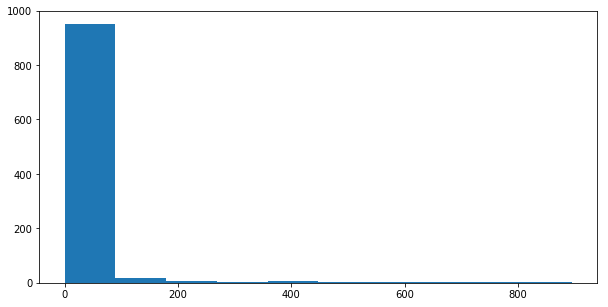

In [68]:
plt.figure(figsize=(10, 5))
plt.hist([rank for rank in ranks if rank is not None])
plt.show()

In [69]:
small = []
for rank in ranks:
    if rank <=3:
        small.append(rank)   
        
print('Mean Rank: ', np.mean(ranks))    
print('Proportion of the Correct Titles In The Top Three Results: ', len(small) / len(ranks)) 

Mean Rank:  16.980885311871226
Proportion of the Correct Titles In The Top Three Results:  0.8370221327967807


# V. Supervised Solution

## 1. Training Set Preparation

In [70]:
training_df = pd.DataFrame()
training_df['text vectors'] = X_train 
training_df['title vectors'] = y_train

In [71]:
X_train.head()

157245    [цена, от, 450, руб, сут, бронировать, хостеть...
54265                             [за, 1400, руб, доставка]
379999    [мобильный, телефон, keneksi, m2, 40, 25, р, г...
692639    [семя, колокольчик, сравнивать, цена, весь, ин...
44467     [купить, lenovo, смартфон, lenovo, a7000, a, b...
Name: atext, dtype: object

In [72]:
y_train.head()

157245           [дом, путешественник, ярославль]
54265                   [чайник, sinbo, sk, 7310]
379999                   [keneksi, m2, 40, 25, р]
692639                        [семя, колокольчик]
44467     [смартфон, lenovo, a7000, a, black, ds]
Name: atitle, dtype: object

In [73]:
test_df = pd.DataFrame()
test_df['text vectors'] = X_test
test_df['title vectors'] = y_test

In [74]:
test_df.head()

,text vectors,title vectors
538096,"[bosch, smv, 65m30, от, 1642, 84, доставка]","[bosch, smv, 65m30]"
482436,"[быть, в, наличие, плиткорез, на, монорельс, 6...","[плиткорез, на, монорельс, 600, мм]"
371034,"[купить, баня, из, брус, под, ключ, высокий, к...","[купить, баня, из, брус, под, ключ]"
201971,"[купить, thrustmaster, джойстик, thrustmaster,...","[thrustmaster, hotas, warthog, 296072]"
599930,"[свитшот, в, интернет, магазин, 3d, футболка, ...","[свитшот, в, интернет, магазин]"


In [75]:
training_df.shape

(133879, 2)

In [76]:
test_df.shape

(57378, 2)

In [77]:
def mixed_df_creator(df):
    
    df_copy = df.copy()
    df_copy = df.reset_index(drop=True)
    
    first_half = df_copy.iloc[:int(len(df_copy)/2)]
    second_half = df_copy.iloc[int(len(df_copy)/2):]
    
    shuffled_titles = shuffle(second_half['title vectors'])
    shuffled_titles = shuffled_titles.reset_index(drop=True)
    
    second_half = second_half.reset_index(drop=True)
    second_half['title vectors'] = shuffled_titles
    
    first_half['pair class'] = 1
    second_half['pair class'] = 0
    
    concat_result = pd.concat([first_half, second_half], axis=0, ignore_index=True)
    
    return concat_result

In [78]:
training_df_mixed = mixed_df_creator(training_df)

In [79]:
test_df_mixed = mixed_df_creator(test_df)

In [80]:
training_df_mixed.tail()

,text vectors,title vectors,pair class
133874,"[карнавальный, костюм, медведь, сравнивать, це...","[гостиница, тибет, воронеж]",0
133875,"[построение, стена, в, 3d, max, обучать, мини,...","[аккумулятор, 6ст, 140]",0
133876,"[edifier, s2000, от, 556, 44, доставка]","[bosch, gex, 125, 150, ave, купить]",0
133877,"[часы, longines, сравнивать, цена, весь, интер...","[мотоблок, huter, gmc, 9, 0, 70, 5, 4]",0
133878,"[купить, intel, процессор, intel, core, i7, 39...","[сколько, стоить, бахила]",0


In [81]:
test_df_mixed.head()

,text vectors,title vectors,pair class
0,"[bosch, smv, 65m30, от, 1642, 84, доставка]","[bosch, smv, 65m30]",1
1,"[быть, в, наличие, плиткорез, на, монорельс, 6...","[плиткорез, на, монорельс, 600, мм]",1
2,"[купить, баня, из, брус, под, ключ, высокий, к...","[купить, баня, из, брус, под, ключ]",1
3,"[купить, thrustmaster, джойстик, thrustmaster,...","[thrustmaster, hotas, warthog, 296072]",1
4,"[свитшот, в, интернет, магазин, 3d, футболка, ...","[свитшот, в, интернет, магазин]",1


In [82]:
training_df_mixed.shape

(133879, 3)

In [83]:
len(result_vector(training_df_mixed.iloc[0, 0])[0])

300

In [84]:
# vectorization of the ads text
text_vectors = []
for row in range(len(training_df_mixed)):
    vector = result_vector(training_df_mixed.iloc[row, 0])
    if vector is not None:  
        text_vectors.append(vector[0])
    else:
        text_vectors.append('M')

In [85]:
training_df_mixed_vectorized = training_df_mixed.copy()

In [86]:
training_df_mixed_vectorized['text vectors'] = text_vectors

In [87]:
# vectorization of the ads text
text_vectors_test = []
for row in range(len(test_df_mixed)):
    vector = result_vector(test_df_mixed.iloc[row, 0])
    if vector is not None:  
        text_vectors_test.append(vector[0])
    else:
        text_vectors_test.append('M')

In [88]:
test_df_mixed_vectorized = test_df_mixed.copy()

In [89]:
test_df_mixed_vectorized['text vectors'] = text_vectors_test

In [90]:
# vectorization of the ads title
title_vectors_tr = []
for row in range(len(training_df_mixed)):
    vector = result_vector(training_df_mixed.iloc[row, 1])
    if vector is not None:  
        title_vectors_tr.append(vector[0])
    else:
        title_vectors_tr.append('M')

In [91]:
training_df_mixed_vectorized['title vectors'] = title_vectors_tr

In [92]:
# vectorization of the ads title
title_vectors_test = []
for row in range(len(test_df_mixed)):
    vector = result_vector(test_df_mixed.iloc[row, 1])
    if vector is not None:  
        title_vectors_test.append(vector[0])
    else:
        title_vectors_test.append('M')

In [93]:
test_df_mixed_vectorized['title vectors'] = title_vectors_test

In [94]:
# remove vectors with that are comprised exclusively of the words that are missing from our vocabulary

training_df_mixed_vectorized= training_df_mixed_vectorized[training_df_mixed_vectorized['text vectors'] != 'M']
training_df_mixed_vectorized = training_df_mixed_vectorized[training_df_mixed_vectorized['title vectors'] != 'M']

test_df_mixed_vectorized= test_df_mixed_vectorized[test_df_mixed_vectorized['text vectors'] != 'M']
test_df_mixed_vectorized = test_df_mixed_vectorized[test_df_mixed_vectorized['title vectors'] != 'M']

In [95]:
training_df_mixed_vectorized.head()

,text vectors,title vectors,pair class
0,"[0.02544660047329015, 0.0011707810425195231, 0...","[0.015198098036355846, -0.05213342759809982, 0...",1
1,"[0.0516573081411133, 0.04961228635702311, 0.17...","[-0.020864336136039073, 0.05624800853075846, 0...",1
2,"[0.05171520681832581, -0.09692307439560113, 0....","[0.06936322380652053, -0.060187326935168685, 0...",1
3,"[-0.0534009538584657, -0.005319961921192986, 0...","[-0.037221739126971624, -0.03195540881985159, ...",1
4,"[0.08585735811197197, -0.01758867201049432, 0....","[0.08681373663851291, 0.01630877987328536, 0.0...",1


In [96]:
test_df_mixed_vectorized.head()

,text vectors,title vectors,pair class
0,"[0.024666528995219074, 0.049405161975092676, 0...","[0.06545065127986378, 0.0780018034864091, 0.01...",1
1,"[0.021816723765101267, 0.024676030341124464, 0...","[0.05880607107079969, 0.05520591482410514, 0.0...",1
2,"[-0.11535827586952777, -0.039044689100362316, ...","[-0.11845730082128247, -0.06688823228895374, 0...",1
3,"[0.05458239301304493, 0.03686340994410696, -0....","[0.08798639535798412, 0.08486310808031754, -0....",1
4,"[-0.049653448006533346, 0.030218458533691293, ...","[-0.03963005196180652, 0.016070349965537634, 0...",1


In [97]:
def cosine_between_rows(row):
    sim = cosine_similarity(row['text vectors'].reshape(1, -1), row['title vectors'].reshape(1, -1))
    return sim

# Cosine Consistency Check

In [98]:
sim_score_one = training_df_mixed_vectorized.iloc[:66939].apply(cosine_between_rows, axis = 1)
sim_score_two = training_df_mixed_vectorized.iloc[66939:].apply(cosine_between_rows, axis = 1)

print('Mean cosine similarity score: first half', np.mean(sim_score_one))
print('Mean cosine similarity score: second half', np.mean(sim_score_two))

Mean cosine similarity score: first half [[0.78024414]]
Mean cosine similarity score: second half [[0.23585755]]


In [99]:
sim_score_one_test = test_df_mixed_vectorized.iloc[:28689].apply(cosine_between_rows, axis = 1)
sim_score_two_test = test_df_mixed_vectorized.iloc[28689:].apply(cosine_between_rows, axis = 1)

print('Mean cosine similarity score: first half', np.mean(sim_score_one_test))
print('Mean cosine similarity score: second half', np.mean(sim_score_two_test))

Mean cosine similarity score: first half [[0.77205639]]
Mean cosine similarity score: second half [[0.24044585]]


In [100]:
training_df_mixed.head()

,text vectors,title vectors,pair class
0,"[цена, от, 450, руб, сут, бронировать, хостеть...","[дом, путешественник, ярославль]",1
1,"[за, 1400, руб, доставка]","[чайник, sinbo, sk, 7310]",1
2,"[мобильный, телефон, keneksi, m2, 40, 25, р, г...","[keneksi, m2, 40, 25, р]",1
3,"[семя, колокольчик, сравнивать, цена, весь, ин...","[семя, колокольчик]",1
4,"[купить, lenovo, смартфон, lenovo, a7000, a, b...","[смартфон, lenovo, a7000, a, black, ds]",1


In [101]:
training_df_mixed.isnull().sum()

text vectors     0
title vectors    0
pair class       0
dtype: int64

In [102]:
training_df_mixed.head()

,text vectors,title vectors,pair class
0,"[цена, от, 450, руб, сут, бронировать, хостеть...","[дом, путешественник, ярославль]",1
1,"[за, 1400, руб, доставка]","[чайник, sinbo, sk, 7310]",1
2,"[мобильный, телефон, keneksi, m2, 40, 25, р, г...","[keneksi, m2, 40, 25, р]",1
3,"[семя, колокольчик, сравнивать, цена, весь, ин...","[семя, колокольчик]",1
4,"[купить, lenovo, смартфон, lenovo, a7000, a, b...","[смартфон, lenovo, a7000, a, black, ds]",1


In [103]:
test_df_mixed.isnull().sum()

text vectors     0
title vectors    0
pair class       0
dtype: int64

In [104]:
def df_converter(df):
    resultant_lists = df['text vectors'].apply(list) + df['title vectors'].apply(list)
    
    #print length for checking the length of concatenated vectors
    print(len(resultant_lists.iloc[0]))
    
    arrays = np.array(list(resultant_lists))
    return arrays

In [105]:
all_training_vectors = df_converter(training_df_mixed_vectorized)

600


In [106]:
all_test_vectors = df_converter(test_df_mixed_vectorized)

600


In [107]:
new_y_training = training_df_mixed_vectorized['pair class']

In [108]:
new_y_test = test_df_mixed_vectorized['pair class']

## 2. PCA And Parameter Finetuning

In [109]:
sample_training_df = training_df_mixed_vectorized.sample(10000, random_state=0)

In [110]:
sample_training_df.head()

,text vectors,title vectors,pair class
100527,"[-0.06564139194051566, 0.032995899964511244, 0...","[0.07408974409360328, -0.034764985742462215, 0...",0
25083,"[0.05884931551291509, -0.049131845362865384, 0...","[0.0858738413626561, -0.09996082926322494, -0....",1
69956,"[-0.039078905295983554, 0.028571696330134108, ...","[-0.008040678539049351, 0.03801823840014913, 0...",0
71144,"[-0.08282363245517602, 0.028861952575292345, 0...","[-0.004116660968997862, -0.03636474826532888, ...",0
118937,"[-0.018110658984371236, 0.13308508856234968, 0...","[-0.058187864019798516, 0.0281978554047003, 0....",0


In [111]:
from sklearn.decomposition import PCA


In [112]:
sample_training_arrays = df_converter(sample_training_df)

600


In [113]:
sample_y = sample_training_df['pair class']

In [114]:
pca_sample = PCA(n_components = 150)
X_train_sample_pca = pca_sample.fit_transform(sample_training_arrays)

In [115]:
X_train_sample_pca.shape

(10000, 150)

In [116]:
print(sum(pca_sample.explained_variance_ratio_))

0.878237057539938


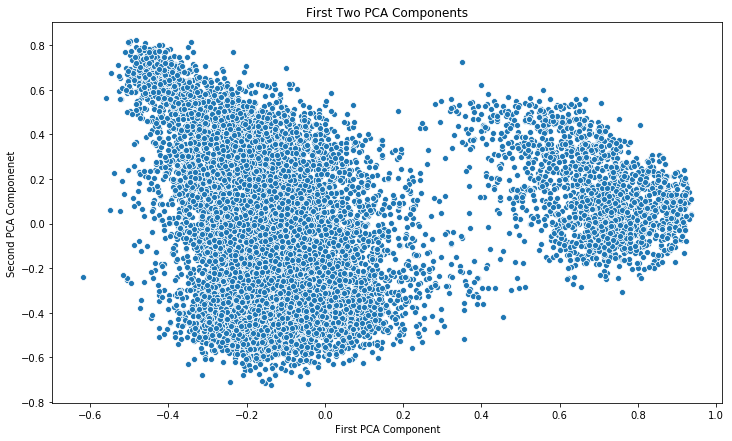

In [117]:
plt.figure(figsize=(12, 7))
plt.title('First Two PCA Components')
sns.scatterplot(X_train_sample_pca[:, 0], X_train_sample_pca[:, 1])
plt.xlabel('First PCA Component')
plt.ylabel('Second PCA Componenet')

plt.show()

## 1. Logistic Regression

In [118]:
from sklearn.linear_model import LogisticRegression

param_grid = [
    {'C': [1e-20, 1e-3,1e-3,  10, 1e2, 1e3],
    'penalty': ['l1', 'l2']}
]
lr = LogisticRegression()

grid_search = GridSearchCV(lr, param_grid, cv =3,
                          scoring= 'accuracy', verbose=1)

grid_search.fit(X_train_sample_pca, sample_y)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:    2.2s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'C': [1e-20, 0.001, 0.001, 10, 100.0, 1000.0], 'penalty': ['l1', 'l2']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=1)

In [119]:
print('Best score', grid_search.best_score_)
print('Best parameters', grid_search.best_params_)

Best score 0.5087
Best parameters {'C': 1e-20, 'penalty': 'l1'}


## 2. Random Forest

In [120]:
param_grid_rfc = [
    {'n_estimators': [100, 500, 700],
    'max_depth': [5, 8, 12, 20, 30]}
]
rfc = RandomForestClassifier(n_jobs = -1)

grid_search_rfc = GridSearchCV(rfc, param_grid_rfc, cv =3,
                          scoring= 'accuracy', verbose=0,
                          n_jobs = -1)

grid_search_rfc.fit(X_train_sample_pca, sample_y)

GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'n_estimators': [100, 500, 700], 'max_depth': [5, 8, 12, 20, 30]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [121]:
print('Best score', grid_search_rfc.best_score_)
print('Best parameters', grid_search_rfc.best_params_)

Best score 0.8856
Best parameters {'max_depth': 30, 'n_estimators': 700}


In [123]:
param_grid_rfc = [
    {'n_estimators': [1000, 1200]
    }
]
rfc_one = RandomForestClassifier(n_jobs = -1, max_depth=30)

grid_search_rfc_one = GridSearchCV(rfc, param_grid_rfc, cv =3,
                          scoring= 'accuracy', verbose=0,
                          n_jobs = -1)

grid_search_rfc_one.fit(X_train_sample_pca, sample_y)

GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'n_estimators': [1000, 1200]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [124]:
print('Best score', grid_search_rfc_one.best_score_)
print('Best parameters', grid_search_rfc_one.best_params_)

Best score 0.8852
Best parameters {'n_estimators': 1000}


In [125]:
from xgboost import XGBClassifier

param_grid_xgb = [
    {'n_estimators': [100, 500, 700],
    'max_depth': [2, 4, 6, 8]
    }
]
xgb = XGBClassifier(n_jobs = -1)

grid_search_xgb = GridSearchCV(xgb, param_grid_xgb, cv =3,
                          scoring= 'accuracy', verbose=0,
                          n_jobs = -1)

grid_search_xgb.fit(X_train_sample_pca, sample_y)

GridSearchCV(cv=3, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'n_estimators': [100, 500, 700], 'max_depth': [2, 4, 6, 8]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [126]:
print('Best score', grid_search_xgb.best_score_)
print('Best parameters', grid_search_xgb.best_params_)

Best score 0.9238
Best parameters {'max_depth': 6, 'n_estimators': 700}


In [127]:
param_grid_xgb_one = [
    {'n_estimators': [700, 1000],
    'learning_rate': [1e-3, 0.5, 0.1],
    }
]
xgb = XGBClassifier(n_jobs = -1, max_depth= 6)

grid_search_xgb_one = GridSearchCV(xgb, param_grid_xgb_one, cv =3,
                          scoring= 'accuracy', verbose=0,
                          n_jobs = -1)

grid_search_xgb_one.fit(X_train_sample_pca, sample_y)

GridSearchCV(cv=3, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=6, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'n_estimators': [700, 1000], 'learning_rate': [0.001, 0.5, 0.1]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [128]:
print('Best score', grid_search_xgb_one.best_score_)
print('Best parameters', grid_search_xgb_one.best_params_)

Best score 0.9271
Best parameters {'learning_rate': 0.1, 'n_estimators': 1000}


In [129]:
param_grid_xgb_two = [
    {'subsample': [0.25, 0.5, 1],
    }
]
xgb = XGBClassifier(n_jobs = -1, max_depth= 6, n_estimators=1000, learning_rate=0.1, )

grid_search_xgb_two = GridSearchCV(xgb, param_grid_xgb_two, cv =3,
                          scoring= 'accuracy', verbose=0,
                          n_jobs = -1)

grid_search_xgb_two.fit(X_train_sample_pca, sample_y)

GridSearchCV(cv=3, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=6, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'subsample': [0.25, 0.5, 1]}], pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='accuracy',
       verbose=0)

In [130]:
print('Best score', grid_search_xgb_two.best_score_)
print('Best parameters', grid_search_xgb_two.best_params_)

Best score 0.9307
Best parameters {'subsample': 0.5}


# VI. Test Set Evaluation

In [131]:
pca_testing = PCA(n_components = 150)
X_train_pca = pca_testing.fit_transform(all_training_vectors)
print(sum(pca_testing.explained_variance_ratio_))

X_test_pca = pca_testing.transform(all_test_vectors)

print(X_test_pca.shape)

0.8751461742520695
(57054, 150)


In [132]:
from sklearn.metrics import f1_score, confusion_matrix, precision_score, recall_score

In [133]:
def probability_calculator(text_vector, title_vectors, model):
    list_concat_arrays = []
    for each in title_vectors:
        resultant_list = list(text_vector) +list(each)
        resultant_array = np.array(list(resultant_list))
        list_concat_arrays.append(resultant_array)
    
    made_array = np.array(list_concat_arrays)
    pca_transformed = pca_testing.transform(made_array)
    predictions = model.predict_proba(pca_transformed)[:, 1]
      
    return predictions

In [134]:
def rank_checker(df, number, model):
    probabilities = probability_calculator(df.iloc[number, 2], df.iloc[:, 3], model)
    series = pd.Series(probabilities, index =df.index)

    sorted_df = series.sort_values(ascending=False)
    sorted_index = sorted_df.index
    
    for rank, entry in enumerate(sorted_index):
        if entry == df.index[number]:
            return rank

In [135]:
def ranks_evaluation(df, model):
    ranks = []
    for row in range(len(test_sample_vectorized)):     
        rank = rank_checker(test_sample_vectorized, row, model)
        ranks.append(rank)

    small = []
    for rank in ranks:
        if rank <=3:
            small.append(rank)   

    print(model) 
    print('Mean Rank: ', np.mean(ranks))    
    print('Proportion of the Correct Titles In The Top Three Results: ', len(small) / len(ranks)) 

    plt.figure(figsize=(10, 5))
    plt.hist(ranks)
    plt.title('Ranks of The Correct Title as Predicted', )
    plt.show()
    return ranks, small

## 1. Logistic Regression

In [136]:
lr_test = LogisticRegression(C= 1e-20, penalty= 'l1')

lr_test.fit(X_train_pca, new_y_training)

print('Accuracy:', lr_test.score(X_test_pca, new_y_test))

Accuracy: 0.5000175272548814


In [137]:
lr_pred = lr_test.predict(X_test_pca)

In [138]:
np.unique(lr_pred, return_counts=True)

(array([0]), array([57054]))

In [139]:
confusion_matrix(new_y_test, lr_pred )

array([[28528,     0],
       [28526,     0]])

In [140]:
print('F1 Score:', f1_score(new_y_test, lr_pred ))

F1 Score: 0.0


In [141]:
print('Recall score:', recall_score(new_y_test, lr_pred ))

Recall score: 0.0


In [142]:
print('Precision score:', precision_score(new_y_test, lr_pred ))

Precision score: 0.0


LogisticRegression(C=1e-20, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Mean Rank:  496.5
Proportion of the Correct Titles In The Top Three Results:  0.004024144869215292


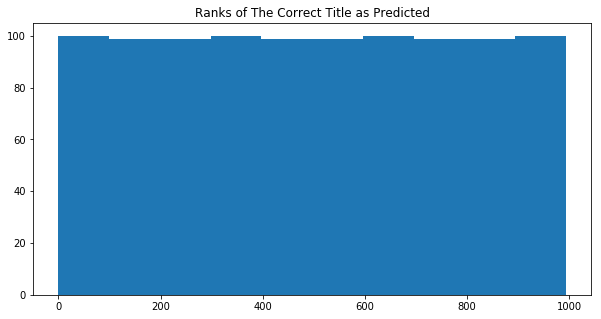

In [143]:
lr_ranks, lr_small = ranks_evaluation(test_sample_vectorized, lr_test)

## 2. Random Forest

In [144]:
rfc_test = RandomForestClassifier(n_jobs = -1, 
                            n_estimators = 1000,
                            max_depth = 30)

rfc_test.fit(X_train_pca, new_y_training)

print('Accuracy:', rfc_test.score(X_test_pca, new_y_test))

Accuracy: 0.9320643600799243


In [145]:
rfc_pred = rfc_test.predict(X_test_pca)
print(confusion_matrix(new_y_test, rfc_pred ))

[[26863  1665]
 [ 2211 26315]]


In [146]:
print('F1 Score:', f1_score(new_y_test, rfc_pred ))

F1 Score: 0.9314055144586415


In [147]:
print('Precision score:', precision_score(new_y_test, rfc_pred ))

Precision score: 0.9404932094353109


In [148]:
print('Recall score:', recall_score(new_y_test, rfc_pred ))

Recall score: 0.9224917619014232


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=30, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Mean Rank:  22.11066398390342
Proportion of the Correct Titles In The Top Three Results:  0.6991951710261569


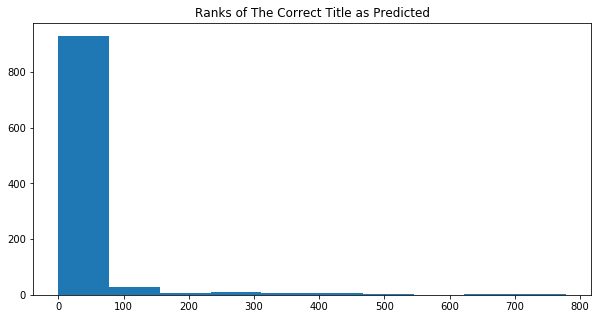

In [149]:
rfc_ranks, rfc_small = ranks_evaluation(test_sample_vectorized, rfc_test)

## 3. XGBoost

In [150]:
xgb_test = XGBClassifier(n_estimators = 1000,
                        max_depth = 6,
                        learning_rate= 0.1,
                        subsample = 0.5)

xgb_test.fit(X_train_pca, new_y_training)

print('Accuracy:', xgb_test.score(X_test_pca, new_y_test))

Accuracy: 0.9656991621972166


In [151]:
xgb_pred = xgb_test.predict(X_test_pca)
print('F1 Score:', f1_score(new_y_test, xgb_pred ))

F1 Score: 0.965586368192449


In [152]:
print(confusion_matrix(new_y_test, xgb_pred))

[[27642   886]
 [ 1071 27455]]


In [154]:
print('Precision score:', precision_score(new_y_test, xgb_pred))

Precision score: 0.9687378709290427


In [155]:
print('Recall score:', recall_score(new_y_test, xgb_pred))

Recall score: 0.9624553039332538


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=6, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.5)
Mean Rank:  10.872233400402415
Proportion of the Correct Titles In The Top Three Results:  0.8470824949698189


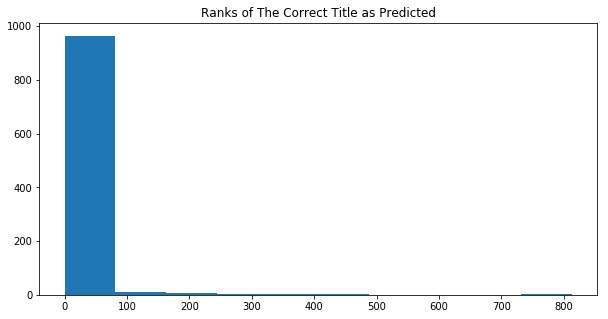

In [156]:
xgb_ranks, xgb_small = ranks_evaluation(test_sample_vectorized, xgb_test)

# VII.  RNN Solution

## 1. Data Preprocessing

In [157]:
test_sample_vectorized.shape

(994, 4)

In [158]:
test_sample_vectorized.head()

,atext,atitle,text vectors,title vectors
0,"[печь, теплодар, топ, купить, здесь, хороший, ...","[печь, теплодар, топ, купить, здесь]","[-0.012165328135384039, -0.05829603946107548, ...","[-0.016803732942445235, -0.01798980556321842, ..."
1,"[покупать, origin, и, др, аккаунт, по, низкий,...","[магазин, игровой, аккаунт, origin]","[0.0026607800340348303, -0.0074289492008903215...","[0.027554853521271537, 0.051067897611309726, 0..."
2,"[обновлять, навигатор, garmin, nuvi, жать]","[обновлять, навигатор, garmin, nuvi]","[-0.013033558059133756, 0.02896459095084477, 0...","[-0.018267125313184626, 0.03579497263279199, 0..."
3,"[полукомбинезон, crockid, сравнивать, цена, ве...","[полукомбинезон, crockid]","[-0.055336739446052684, 0.023552204905021065, ...","[-0.011259474332971536, -0.008995498843055555,..."
4,"[декоративный, зеркало, сравнивать, цена, весь...","[декоративный, зеркало]","[-0.07637128225902386, 0.03493874623990901, 0....","[-0.06736673179332726, 0.027085589694762553, 0..."


In [159]:
training_df_mixed.head()

,text vectors,title vectors,pair class
0,"[цена, от, 450, руб, сут, бронировать, хостеть...","[дом, путешественник, ярославль]",1
1,"[за, 1400, руб, доставка]","[чайник, sinbo, sk, 7310]",1
2,"[мобильный, телефон, keneksi, m2, 40, 25, р, г...","[keneksi, m2, 40, 25, р]",1
3,"[семя, колокольчик, сравнивать, цена, весь, ин...","[семя, колокольчик]",1
4,"[купить, lenovo, смартфон, lenovo, a7000, a, b...","[смартфон, lenovo, a7000, a, black, ds]",1


In [160]:
training_df_mixed.iloc[:5, 1]

0           [дом, путешественник, ярославль]
1                  [чайник, sinbo, sk, 7310]
2                   [keneksi, m2, 40, 25, р]
3                        [семя, колокольчик]
4    [смартфон, lenovo, a7000, a, black, ds]
Name: title vectors, dtype: object

In [161]:
merged_trainig_examples = training_df_mixed.iloc[:, 1]+training_df_mixed.iloc[:, 0]

In [162]:
len(merged_trainig_examples)

133879

In [163]:
merged_test_examples = test_df_mixed.iloc[:, 1]+test_df_mixed.iloc[:, 0]

In [164]:
len(merged_test_examples)

57378

In [165]:
max([len(x) for x in merged_trainig_examples])

28

In [166]:
max([len(x) for x in merged_test_examples])

28

In [167]:
training_df_mixed['concatenated_text_title'] = training_df_mixed['text vectors'] + training_df_mixed['title vectors']

In [168]:
test_df_mixed['concatenated_text_title'] = test_df_mixed['text vectors'] + test_df_mixed['title vectors']

In [169]:
test_df_mixed['concatenated_text_title'].head()

0    [bosch, smv, 65m30, от, 1642, 84, доставка, bo...
1    [быть, в, наличие, плиткорез, на, монорельс, 6...
2    [купить, баня, из, брус, под, ключ, высокий, к...
3    [купить, thrustmaster, джойстик, thrustmaster,...
4    [свитшот, в, интернет, магазин, 3d, футболка, ...
Name: concatenated_text_title, dtype: object

In [170]:
training_df_mixed.head()

,text vectors,title vectors,pair class,concatenated_text_title
0,"[цена, от, 450, руб, сут, бронировать, хостеть...","[дом, путешественник, ярославль]",1,"[цена, от, 450, руб, сут, бронировать, хостеть..."
1,"[за, 1400, руб, доставка]","[чайник, sinbo, sk, 7310]",1,"[за, 1400, руб, доставка, чайник, sinbo, sk, 7..."
2,"[мобильный, телефон, keneksi, m2, 40, 25, р, г...","[keneksi, m2, 40, 25, р]",1,"[мобильный, телефон, keneksi, m2, 40, 25, р, г..."
3,"[семя, колокольчик, сравнивать, цена, весь, ин...","[семя, колокольчик]",1,"[семя, колокольчик, сравнивать, цена, весь, ин..."
4,"[купить, lenovo, смартфон, lenovo, a7000, a, b...","[смартфон, lenovo, a7000, a, black, ds]",1,"[купить, lenovo, смартфон, lenovo, a7000, a, b..."


In [171]:
training_df_mixed['concatenated_text_title'][3]

['семя',
 'колокольчик',
 'сравнивать',
 'цена',
 'весь',
 'интернет',
 'магазин',
 'на',
 'семя',
 'семя',
 'колокольчик']

In [172]:
import keras.utils as ku 
from keras.preprocessing.sequence import pad_sequences

In [173]:
import keras

from keras.utils import to_categorical
y_reshaped_tr = to_categorical(training_df_mixed['pair class'], 2)
y_reshaped_test = to_categorical(test_df_mixed['pair class'], 2)

In [174]:
word_vectors = model.wv

In [175]:
len(word_vectors['нужно'])

300

In [176]:
print("Number of word vectors: {}".format(len(word_vectors.vocab)))

Number of word vectors: 19849


In [177]:
model.wv.most_similar_cosmul(positive=['компьютер']) 

[('настройка', 0.7941992878913879),
 ('починять', 0.749427080154419),
 ('чистка', 0.7436109781265259),
 ('администратор', 0.7422517538070679),
 ('обслуживание', 0.7417911887168884),
 ('пк', 0.7386230826377869),
 ('приезжать', 0.7334417104721069),
 ('аутсорсинг', 0.7274552583694458),
 ('выезд', 0.7231505513191223),
 ('сломаться', 0.7178391218185425)]

In [178]:
MAX_NB_WORDS = len(word_vectors.vocab)
MAX_SEQUENCE_LENGTH = 30

In [179]:
from collections import Counter
vocab=Counter()

for entry in training_df_mixed['concatenated_text_title']:
    vocab.update(entry)

In [180]:
MAX_NB_WORDS

19849

In [181]:
word_index = {t[0]: i+1 for i,t in enumerate(vocab.most_common(MAX_NB_WORDS))}

In [182]:
training_sequences = [[word_index.get(t, 0) for t in ad_title_combo]
             for ad_title_combo in training_df_mixed['concatenated_text_title']]

In [183]:
test_sequences = [[word_index.get(t, 0)  for t in ad_title_combo] 
                  for ad_title_combo in test_df_mixed['concatenated_text_title']]

In [184]:
# pad sequences
data = pad_sequences(training_sequences, maxlen=MAX_SEQUENCE_LENGTH, 
                     padding="pre", truncating="post")

In [185]:
training_df_mixed.head()

,text vectors,title vectors,pair class,concatenated_text_title
0,"[цена, от, 450, руб, сут, бронировать, хостеть...","[дом, путешественник, ярославль]",1,"[цена, от, 450, руб, сут, бронировать, хостеть..."
1,"[за, 1400, руб, доставка]","[чайник, sinbo, sk, 7310]",1,"[за, 1400, руб, доставка, чайник, sinbo, sk, 7..."
2,"[мобильный, телефон, keneksi, m2, 40, 25, р, г...","[keneksi, m2, 40, 25, р]",1,"[мобильный, телефон, keneksi, m2, 40, 25, р, г..."
3,"[семя, колокольчик, сравнивать, цена, весь, ин...","[семя, колокольчик]",1,"[семя, колокольчик, сравнивать, цена, весь, ин..."
4,"[купить, lenovo, смартфон, lenovo, a7000, a, b...","[смартфон, lenovo, a7000, a, black, ds]",1,"[купить, lenovo, смартфон, lenovo, a7000, a, b..."


In [186]:
data.shape

(133879, 30)

In [188]:
# pad sequences
test_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH, 
                     padding="pre", truncating="post")

In [191]:
test_data.shape

(57378, 30)

In [192]:
y_reshaped_tr.shape

(133879, 2)

In [193]:
y_reshaped_test.shape

(57378, 2)

In [194]:
MAX_NB_WORDS

19849

In [195]:
len(word_vectors.vocab)

19849

In [196]:
WV_DIM = 300
nb_words = min(MAX_NB_WORDS, len(word_vectors.vocab))

In [197]:
length_maxtrix = len(word_vectors.vocab)+1

embedding_matrix = np.zeros((length_maxtrix, 300))

for word, i in word_index.items():
    if i >= MAX_NB_WORDS:
            continue
    try:        
        embedding_vector = word_vectors[word]
        # words not found in embedding index will be all-zeros.
        if embedding_vector is not None:  
            embedding_matrix[i] = embedding_vector
    except:
        pass

In [198]:
embedding_matrix.shape

(19850, 300)

## 2. Model Training

In [199]:
from keras.layers import Dense, Input, Embedding, Dropout,  GRU, Bidirectional
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization

In [245]:
model_rnn = Sequential()
model_rnn.add(Embedding(nb_words+1,
                     WV_DIM,
                     mask_zero=False,
                     weights=[embedding_matrix],
                     input_length=MAX_SEQUENCE_LENGTH,
                     trainable=False))

model_rnn.add(Bidirectional(GRU(500)))
model_rnn.add(Dropout(0.5))

model_rnn.add(BatchNormalization())
model_rnn.add(Dense(2, activation = 'softmax'))

model_rnn.compile(loss='categorical_crossentropy', 
                   optimizer = 'adam', 
                   metrics = ['accuracy']) 

In [246]:
len(y_reshaped_tr)

133879

In [249]:
model_rnn.fit(data, y_reshaped_tr, 
               verbose = 1, 
               epochs=15, 
               batch_size=256,
               shuffle=True,
               validation_data = (test_data, y_reshaped_test))

Train on 133879 samples, validate on 57378 samples
Epoch 1/15
133879/133879 [==============================] - 620s 5ms/step - loss: 0.3689 - acc: 0.8287 - val_loss: 0.1808 - val_acc: 0.9323
Epoch 2/15
133879/133879 [==============================] - 637s 5ms/step - loss: 0.1270 - acc: 0.9532 - val_loss: 0.1232 - val_acc: 0.9547
Epoch 3/15
133879/133879 [==============================] - 707s 5ms/step - loss: 0.0741 - acc: 0.9736 - val_loss: 0.1237 - val_acc: 0.9558
Epoch 4/15
133879/133879 [==============================] - 661s 5ms/step - loss: 0.0481 - acc: 0.9830 - val_loss: 0.1105 - val_acc: 0.9630
Epoch 5/15
133879/133879 [==============================] - 646s 5ms/step - loss: 0.0350 - acc: 0.9876 - val_loss: 0.1277 - val_acc: 0.9620
Epoch 6/15
133879/133879 [==============================] - 657s 5ms/step - loss: 0.0269 - acc: 0.9906 - val_loss: 0.1237 - val_acc: 0.9625
Epoch 7/15
133879/133879 [==============================] - 663s 5ms/step - loss: 0.0226 - acc: 0.9922 - val_

## 3. Model Evaluation

In [250]:
def probability_calculator_rnn(text_vector, title_vectors, model):
    list_concat_arrays = []
    for each in title_vectors:
        resultant_list = list(text_vector) +list(each)
        resultant_array = np.array(list(resultant_list))
        list_concat_arrays.append(resultant_array)
    
    made_array = np.array(list_concat_arrays)
    training_sequences = [[word_index.get(t, 0) for t in combo]
                         for combo in  made_array]
    training_padded = pad_sequences(training_sequences, maxlen=MAX_SEQUENCE_LENGTH, 
                     padding="pre", truncating="post")         
    predictions = model.predict(training_padded)[:, 1]
        
    return predictions

In [251]:
def rank_checker_rnn (df, number, model):
    probabilities = probability_calculator_rnn(df.iloc[number, 0], df.iloc[:, 1], model)
    series = pd.Series(probabilities, index =df.index)

    sorted_df = series.sort_values(ascending=False)
    sorted_index = sorted_df.index
    
    for rank, entry in enumerate(sorted_index):
        if entry == df.index[number]:
            return rank

In [252]:
ranks_rnn = []
for row in range(len(sample_test_df_checking)):     
    rank = rank_checker_rnn(sample_test_df_checking, row, model_rnn)

    ranks_rnn.append(rank)

In [253]:
np.mean(ranks_rnn)

9.9

In [254]:
small_rnn = []
for rank in ranks_rnn:
    if rank <=3:
        small_rnn.append(rank)

In [255]:
len(small_rnn)/ len(ranks_rnn)

0.783

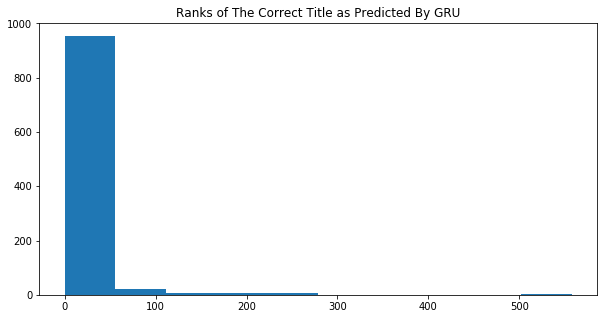

In [256]:
plt.figure(figsize=(10, 5))
plt.hist([rank for rank in ranks_rnn])
plt.title('Ranks of The Correct Title as Predicted By GRU')
plt.show()

In [261]:
for model_rnn.predict(test_data[:2])[:, :]

array([[1.4634598e-03, 9.9853659e-01],
       [3.9681250e-05, 9.9996030e-01]], dtype=float32)

In [267]:
predictions = []
for prob in model_rnn.predict(test_data)[:, :]:
    if prob[0] > prob[1]:
        predictions.append(0)
    else:
        predictions.append(1)

In [268]:
len(predictions)

57378

In [269]:
len(test_df_mixed['pair class'])

57378

In [270]:
print('F1 Score:', f1_score(test_df_mixed['pair class'], predictions ))

F1 Score: 0.9642677053085497


In [271]:
print(confusion_matrix(test_df_mixed['pair class'], predictions))

[[27595  1094]
 [  961 27728]]


In [273]:
print('Precision score:', precision_score(test_df_mixed['pair class'], predictions))

Precision score: 0.9620428839081258


In [274]:
print('Recall score:', recall_score(test_df_mixed['pair class'], predictions))

Recall score: 0.9665028408100665
